Criando o Backtest da Estratégia de IFR2 em Python.

Fonte: https://quantbrasil.com.br/criando-o-backtest-da-estrategia-de-ifr2-em-python/

In [1]:
%%capture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor

%pip install yfinance
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define backtest parameters
initial_capital = 20000
total_capital = [initial_capital]  # list with the total capital after every operation
all_profits = []  # list with profits for every operation
ongoing = False

# RSI parameters
rsi_parameter = 30
rsi_target = 2 # highest high of the last X candles.

In [3]:
df = yf.download("BOVA11.SA", start="2018-01-01", end="2024-01-01").copy()[["Open", "High", "Close", "Adj Close"]]
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Close,Adj Close
Date,,,,
2018-01-02,74.000000,75.230003,75.099998,75.099998
2018-01-03,75.000000,75.769997,75.300003,75.300003
2018-01-04,75.540001,76.440002,76.000000,76.000000
2018-01-05,76.000000,76.440002,76.440002,76.440002
2018-01-08,76.330002,76.760002,76.760002,76.760002


In [4]:
def rsi(data, column, window=2):

    data = data.copy()

    # Establish gains and losses for each day
    data["Variation"] = data[column].diff()
    data = data[1:]
    data["Gain"] = np.where(data["Variation"] > 0, data["Variation"], 0)
    data["Loss"] = np.where(data["Variation"] < 0, data["Variation"], 0)

    # Calculate simple averages so we can initialize the classic averages
    simple_avg_gain = data["Gain"].rolling(window).mean()
    simple_avg_loss = data["Loss"].abs().rolling(window).mean()
    classic_avg_gain = simple_avg_gain.copy()
    classic_avg_loss = simple_avg_loss.copy()

    for i in range(window, len(classic_avg_gain)):
        classic_avg_gain[i] = (classic_avg_gain[i - 1] * (window - 1) + data["Gain"].iloc[i]) / window
        classic_avg_loss[i] = (classic_avg_loss[i - 1] * (window - 1) + data["Loss"].abs().iloc[i]) / window

    # Calculate the RSI
    RS = classic_avg_gain / classic_avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

In [5]:
df["IFR2"] = rsi(df, column="Adj Close")
df.head()

,Open,High,Close,Adj Close,IFR2
Date,,,,,
2018-01-02,74.000000,75.230003,75.099998,75.099998,NaN
2018-01-03,75.000000,75.769997,75.300003,75.300003,NaN
2018-01-04,75.540001,76.440002,76.000000,76.000000,100.0
2018-01-05,76.000000,76.440002,76.440002,76.440002,100.0
2018-01-08,76.330002,76.760002,76.760002,76.760002,100.0


In [6]:
target_columns = []

for shift in range(1, (rsi_target + 1)):
    column_name = f"Target{shift}"
    df[column_name] = df["High"].shift(shift)
    target_columns.append(column_name)

df["Target"] = df[target_columns].max(axis=1)


df.drop(columns=target_columns, inplace=True)
df.head()

,Open,High,Close,Adj Close,IFR2,Target
Date,,,,,,
2018-01-02,74.000000,75.230003,75.099998,75.099998,NaN,NaN
2018-01-03,75.000000,75.769997,75.300003,75.300003,NaN,75.230003
2018-01-04,75.540001,76.440002,76.000000,76.000000,100.0,75.769997
2018-01-05,76.000000,76.440002,76.440002,76.440002,100.0,76.440002
2018-01-08,76.330002,76.760002,76.760002,76.760002,100.0,76.440002


In [7]:
df["Buy Price"] = np.where(df["IFR2"] <= rsi_parameter, df["Close"], np.nan)

# Define exact sell price
df["Sell Price"] = np.where(
    df["High"] > df["Target"], np.where(df["Open"] > df["Target"], df["Open"], df["Target"]), np.nan
)

df.head()

,Open,High,Close,Adj Close,IFR2,Target,Buy Price,Sell Price
Date,,,,,,,,
2018-01-02,74.000000,75.230003,75.099998,75.099998,NaN,NaN,NaN,NaN
2018-01-03,75.000000,75.769997,75.300003,75.300003,NaN,75.230003,NaN,75.230003
2018-01-04,75.540001,76.440002,76.000000,76.000000,100.0,75.769997,NaN,75.769997
2018-01-05,76.000000,76.440002,76.440002,76.440002,100.0,76.440002,NaN,NaN
2018-01-08,76.330002,76.760002,76.760002,76.760002,100.0,76.440002,NaN,76.440002


In [8]:
# Create a function to round any number to the smalles multiple of 100
def round_down(x):
    return int(floor(x / 100.0)) * 100

In [9]:
# Criando o algoritmo para simular as operações
for i in range(0, len(df)):
    if ongoing == True:

        if ~(np.isnan(df["Sell Price"][i])):
            # Define exit point and total profit
            exit = df["Sell Price"][i]
            profit = shares * (exit - entry)

            # Append profit to list and create a new entry with the capital
            # after the operation is complete
            all_profits += [profit]
            current_capital = total_capital[-1]  # current capital is the last entry in the list
            total_capital += [current_capital + profit]
            ongoing = False
    else:
        if ~(np.isnan(df["Buy Price"][i])):
            entry = df["Buy Price"][i]
            shares = round_down(initial_capital / entry)
            ongoing = True

In [10]:
def strategy_test(all_profits):
    num_operations = len(all_profits)
    gains = sum(x >= 0 for x in all_profits)
    pct_gains = 100 * (gains / num_operations)
    losses = num_operations - gains
    pct_losses = 100 - pct_gains

    print("Number of operations =", num_operations)
    print("Number of gains =", gains, "or", pct_gains.round(2), "%")
    print("Number of loss =", losses, "or", pct_losses.round(2), "%")
    print("The total profit was = R$", sum(all_profits).round(2), f"({((sum(all_profits)/initial_capital)*100).round(2)}%)")

strategy_test(all_profits)

Number of operations = 166
Number of gains = 123 or 74.1 %
Number of loss = 43 or 25.9 %
The total profit was = R$ 13975.99 (69.88%)


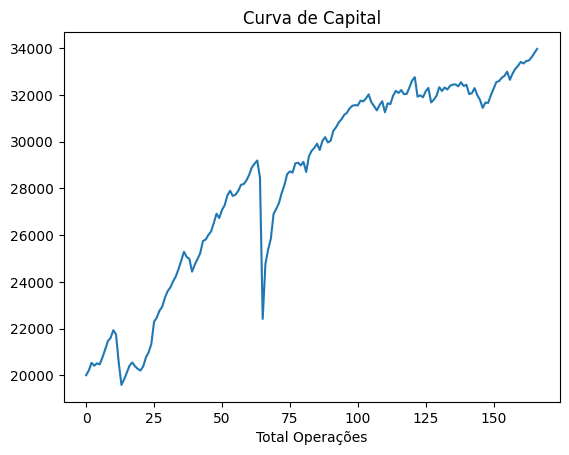

In [11]:
def capital_plot(total_capital, all_profits):
    all_profits = [0] + all_profits # make sure both lists are the same size
    cap_evolution = pd.DataFrame({'Capital': total_capital, 'Profit': all_profits})
    plt.title("Curva de Capital")
    plt.xlabel("Total Operações")
    cap_evolution['Capital'].plot()

capital_plot(total_capital, all_profits)